# Project- Prediction of churn
## Qinpei DU   08/2021


# package

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report,precision_score
from sklearn.metrics import plot_confusion_matrix

Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

-Customers who left within the last month – the column is called Churn

-Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

-Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

-Demographic info about customers – gender, age range, and if they have partners and dependents

Target:

The goal is to build a model to estimate if a customer will abandon the service or not, based on the behavior. In the dataframe, each row represents a customer, each column contains customer’s attributes described on the column Metadata.

# Dataset and basic analysis

In [28]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df["gender"].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

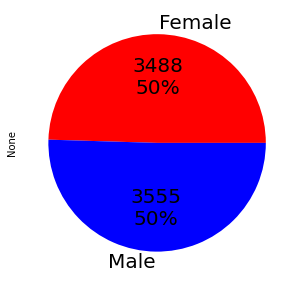

In [5]:
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))

df.groupby('gender').size().plot(kind='pie',autopct=label_function,textprops={'fontsize': 20},
                                  colors=['r', 'b'], ax=ax1)

plt.show()

It shows that the gender is quite balanced

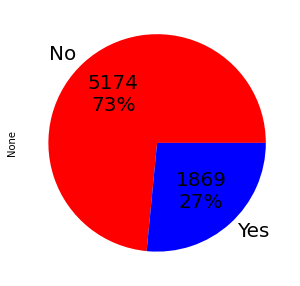

In [6]:
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))

df.groupby('Churn').size().plot(kind='pie',autopct=label_function,textprops={'fontsize': 20},
                                  colors=['r', 'b'], ax=ax1)

plt.show()

The data is unbalanced since there are much more "NO" than "Yes", which means we cant focus only on the accuracy of the model.

In [17]:
for c in df.columns:
    print ("---- %s ---" % c)
    print (df[c].value_counts())

---- customerID ---
8715-KKTFG    1
0376-OIWME    1
7878-RTCZG    1
6583-SZVGP    1
2371-JQHZZ    1
             ..
0374-IOEGQ    1
4277-BWBML    1
5593-SUAOO    1
3665-JATSN    1
6360-SVNWV    1
Name: customerID, Length: 7043, dtype: int64
---- gender ---
Male      3555
Female    3488
Name: gender, dtype: int64
---- SeniorCitizen ---
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
---- Partner ---
No     3641
Yes    3402
Name: Partner, dtype: int64
---- Dependents ---
No     4933
Yes    2110
Name: Dependents, dtype: int64
---- tenure ---
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64
---- PhoneService ---
Yes    6361
No      682
Name: PhoneService, dtype: int64
---- MultipleLines ---
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
---- InternetService ---
Fiber optic    3096
DSL            2421
No             1526
Name

We see that for the column "customer ID", there are 7043 different values, which means each customer id is different and we have 7043 different customers.

In [29]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

we see that there are 11 null values in column TotalCharges, and I will delete these 11 rows. After that I change the values of column "churn" into 0 or 1. And we also delete customer id column for further modeling.

In [37]:
# delete these 11 rows and customer id colone
df.dropna(inplace=True)
df2 = df.iloc[:,1:]

#change Churn yes/no into 1/0
df2['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df2['Churn'].replace(to_replace='No',  value=0, inplace=True)
df2

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1


## analysis of relationhsip

 gender:

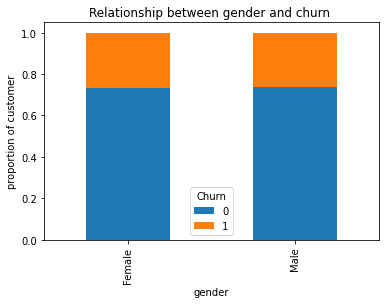

In [38]:
table = pd.crosstab(df2["gender"],df2["Churn"])
table.div(table.sum(1).astype(float),axis = 0).plot(kind = "bar",stacked = True)
plt.title("Relationship between gender and churn ")
plt.xlabel("gender")
plt.ylabel("proportion of customer")
plt.show()

for all categorical variables, lets analyse the relationship with churn, draw figures which represent the proportion of customers who choose to churn, and delete some columns which have less relationship with churn 

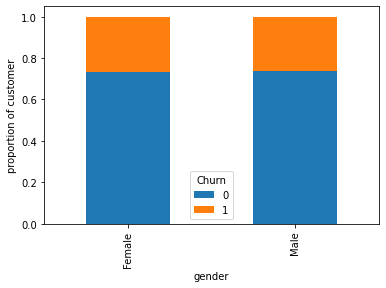

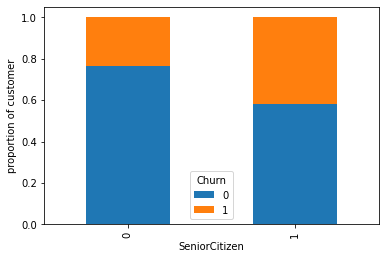

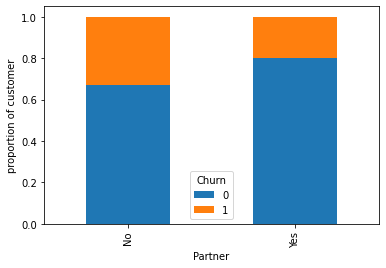

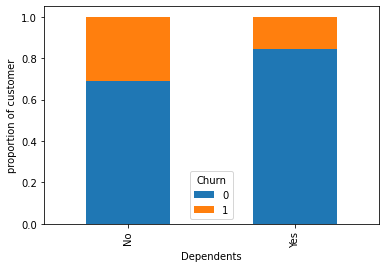

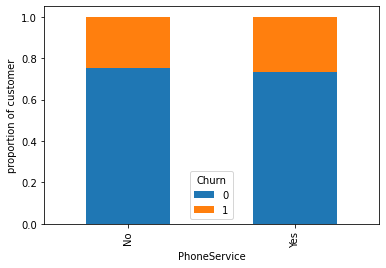

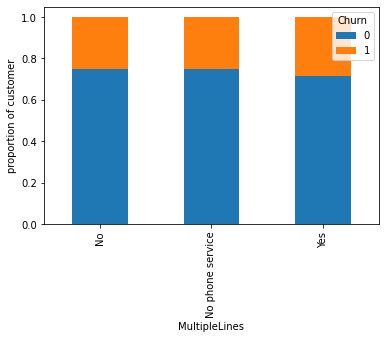

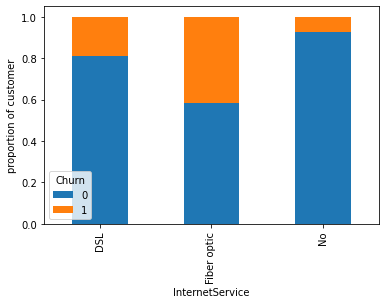

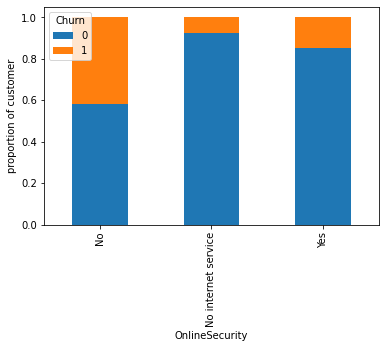

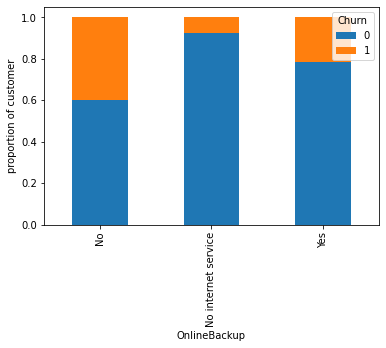

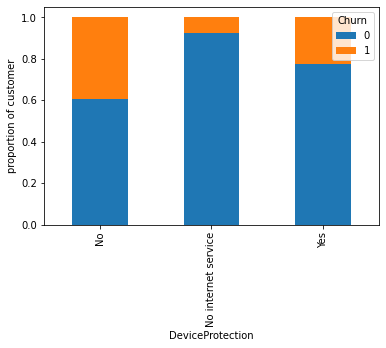

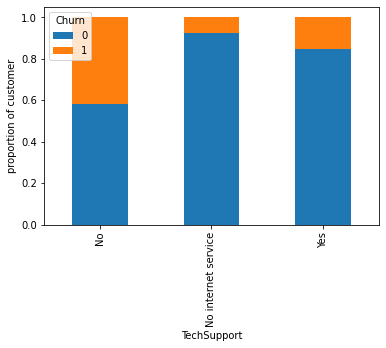

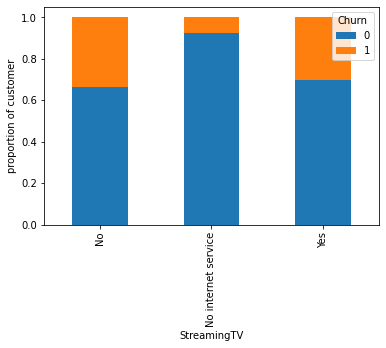

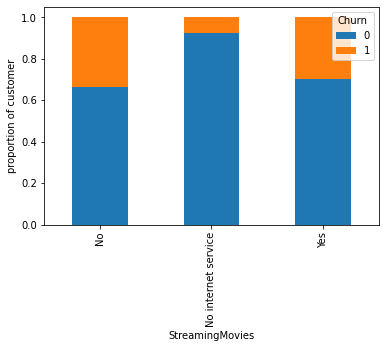

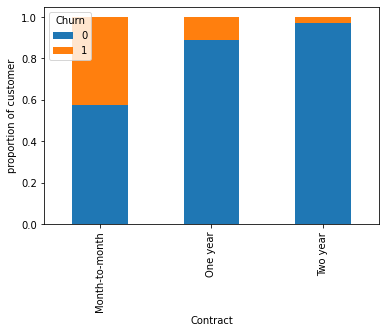

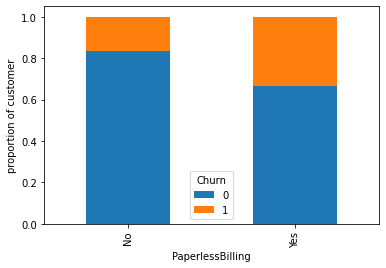

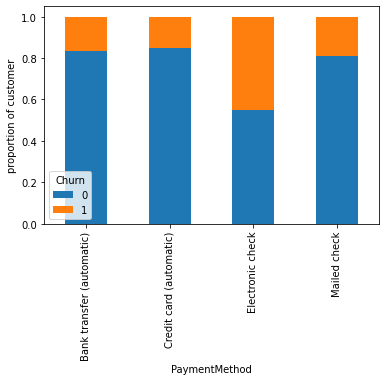

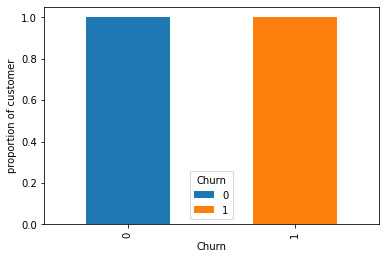

In [39]:
for index, row in df2.iteritems():
  if (index != "MonthlyCharges" and index !="TotalCharges" and index != "tenure"):
    table = pd.crosstab(df2[index],df2["Churn"])
    table.div(table.sum(1).astype(float),axis = 0).plot(kind = "bar",stacked = True)
    #plt.title(index)
    plt.xlabel(index)
    plt.ylabel("proportion of customer")
    plt.show()

So we can see that the columns "gender","Multiple lines" and "phone service" dont have a obvious relationship with churn(churn or not doesn't depend to much on these columns)

# Training data set and test data set

delete "gender","Multiple lines" and "phone service" columns, and change all categorical values into numerical values

In [40]:
df2 = df2.drop(['gender','MultipleLines','PhoneService'], axis = 1)
df_dummies = pd.get_dummies(df2)
df_dummies

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,0,1,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990.50,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1
7039,0,72,103.20,7362.90,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0
7040,0,11,29.60,346.45,0,0,1,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
7041,1,4,74.40,306.60,1,0,1,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1


split training data and test data

In [41]:
y = df_dummies['Churn'].values
X = df_dummies.drop(columns=['Churn'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,random_state = 42)

I will use two models: Logistic regression and lightGBM

# logistic regression 

## With default parameters



In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)
# default parameters

accuracy:

In [ ]:
from sklearn import metrics
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print (metrics.accuracy_score(y_test, prediction_test))

0.7987936234381732


In [ ]:
y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [ ]:
print(f1_score(y_test, y_pred))

0.5781391147244807


In [ ]:
print(recall_score(y_test,y_pred))

0.5245901639344263


In [ ]:
print(precision_score(y_test,y_pred))

0.6438631790744467


In [ ]:
print(roc_auc_score(y_test,y_pred))

0.7105709440361787


confusion matrix:

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1534  177]
 [ 290  320]]


[[1534  177]
 [ 290  320]]


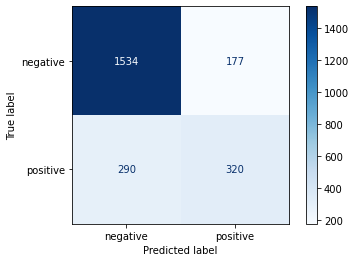

In [ ]:
class_names = ['negative','positive']
disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, values_format = '.5g')



print(disp.confusion_matrix)

Which means we have 1534+320 = 1854 correct predictions and 290+320 = 467 wrong predictions

$$accuracy = \frac {True \ Positive + True \ Negative}{True \ Positive + \ False \ Positive + True \ Negative + \ False \ Negative }$$

precision: 
$$precision = \frac {True \ Positive}{True \ Positive + \ False \ Positive}$$

In [ ]:
precision_regression = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1])
print('Precision  of logistic regression classifier on test set: {:.2f}'\
      .format(precision_regression))

Precision  of logistic regression classifier on test set: 0.64


Recall (True positive rate):
$$Recall = \frac {True \ Positive}{True \ Positive + \ False \ Negative}$$

In [ ]:
recall_regression = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0])
print('Recall  of logistic regression classifier on test set: {:.2f}'\
      .format(recall_regression))

Recall  of logistic regression classifier on test set: 0.52


F1 score:
$$F1\ Score = 2 * \frac {Precision * Recall}{Precision + Recall}$$

In [ ]:
f_score_regression = 2 * precision_regression*recall_regression/(precision_regression+recall_regression)
print('F1 Score  of logistic regression classifier on test set: {:.2f}'\
      .format(f_score_regression))

F1 Score  of logistic regression classifier on test set: 0.58


report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1711
           1       0.64      0.52      0.58       610

    accuracy                           0.80      2321
   macro avg       0.74      0.71      0.72      2321
weighted avg       0.79      0.80      0.79      2321



ROC curve

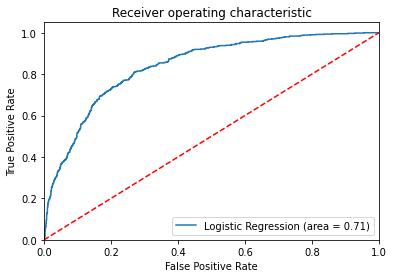

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

feature importance

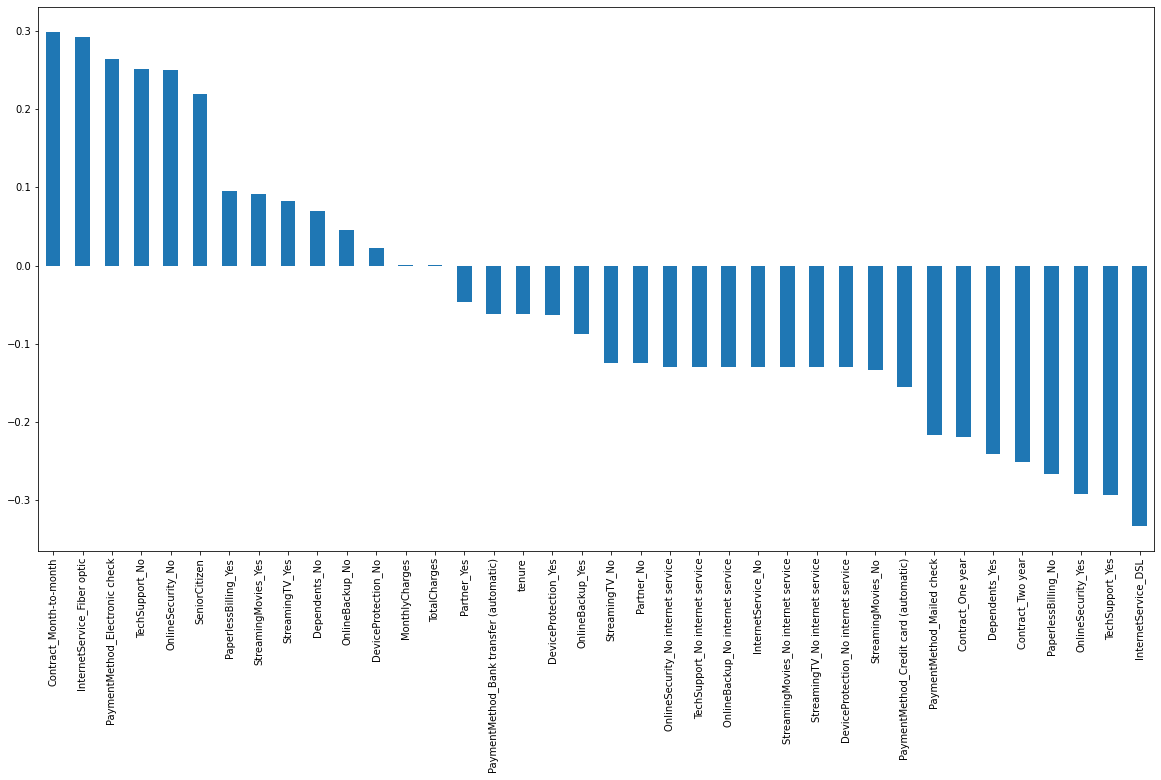

In [ ]:
weights = pd.Series(model.coef_[0],
                 index=X.columns.values)
plt.figure(figsize=(20, 10))
weights.sort_values(ascending = False).plot(kind='bar')

## Change some parameters in regression fonction

### Without penalty

In [ ]:
from sklearn.linear_model import LogisticRegression
model_nopenalty = LogisticRegression(penalty = "none")
result = model_nopenalty.fit(X_train, y_train)
# no penalty

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
from sklearn import metrics
prediction_test_np = model_nopenalty.predict(X_test)
# Print the prediction accuracy
print (metrics.accuracy_score(y_test, prediction_test_np))

0.7975010771219302


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, prediction_test_np)
print(confusion_matrix)

[[1522  189]
 [ 281  329]]


[[1522  189]
 [ 281  329]]


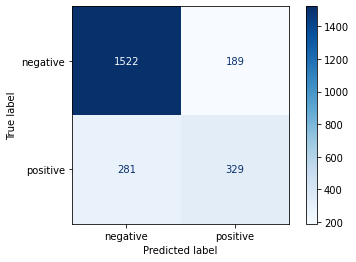

In [ ]:
class_names = ['negative','positive']
disp = plot_confusion_matrix(model_nopenalty, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.5g')



print(disp.confusion_matrix)

In [ ]:
y_pred_np = model_nopenalty.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model_nopenalty.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [ ]:
print(precision_score(y_test,y_pred_np))

0.6351351351351351


In [ ]:
print(recall_score(y_test,y_pred_np))

0.5393442622950819


In [ ]:
print(f1_score(y_test,y_pred_np))

0.5833333333333334


In [ ]:
print(roc_auc_score(y_test,y_pred_np))

0.7144412720008432


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_np))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1711
           1       0.64      0.54      0.58       610

    accuracy                           0.80      2321
   macro avg       0.74      0.71      0.72      2321
weighted avg       0.79      0.80      0.79      2321



We can see that comparing with penalty L2, no penalty gives a slightly lower accuracy and a higher recall.

### different tolerance


In [ ]:
tol = [1e-5,5e-5,1e-4,5e-4,1e-2]
accuracy_tol = []
for tolerance in tol:
    model_tol = LogisticRegression(tol = tolerance)
    result_tol = model_tol.fit(X_train, y_train)
    prediction_test_tol = model_tol.predict(X_test)
    accuracy_tol.append(metrics.accuracy_score(y_test, prediction_test_tol))

accuracy_tol

[0.7987936234381732,
 0.7987936234381732,
 0.7987936234381732,
 0.7987936234381732,
 0.7987936234381732]

Different tolerances seem to be useless in this model :)

### Different C value

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


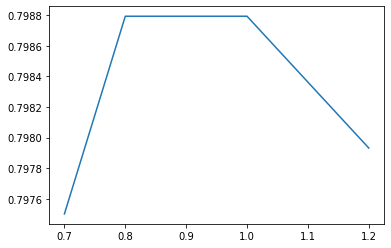

In [ ]:
C = [0.7,0.8,1,1.2]
acc_c = []
for c in C:
    model_c = LogisticRegression(C = c)
    result_c = model_c.fit(X_train,y_train)
    prediction_test_c = model_c.predict(X_test)
    acc_c.append(metrics.accuracy_score(y_test,prediction_test_c))
plt.plot(C,acc_c)

We would just use the default c value

# LGBM

## Default parameters

In [ ]:
lgbm_clf = lgbm.LGBMClassifier()

lgbm_clf.fit(X_train,y_train)

y_pred_lgbm = lgbm_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
acc_lgbm = accuracy_score(y_pred_lgbm, y_test)
print('LGBM Model accuracy score:{0:0.4f}'.format(acc_lgbm))

LGBM Model accuracy score:0.7859


In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_pred_lgbm, y_test))

0.72281396155065


In [ ]:
print(precision_score(y_test,y_pred_lgbm))

0.6080305927342257


In [ ]:
print(recall_score(y_test,y_pred_lgbm))

0.521311475409836


In [ ]:
print(f1_score(y_test,y_pred_lgbm))

0.5613415710503089


[[1506  205]
 [ 292  318]]


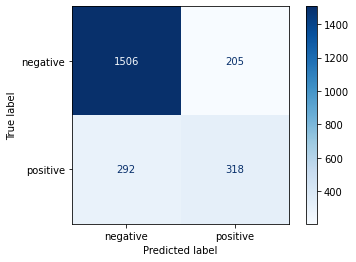

In [ ]:
class_names = ['negative','positive']
disp = plot_confusion_matrix(lgbm_clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, values_format = '.5g')



print(disp.confusion_matrix)

The accuracy is less than that of logistic regression

In [ ]:
from sklearn.metrics import confusion_matrix
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
cm_lgbm

array([[1506,  205],
       [ 292,  318]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1711
           1       0.61      0.52      0.56       610

    accuracy                           0.79      2321
   macro avg       0.72      0.70      0.71      2321
weighted avg       0.78      0.79      0.78      2321



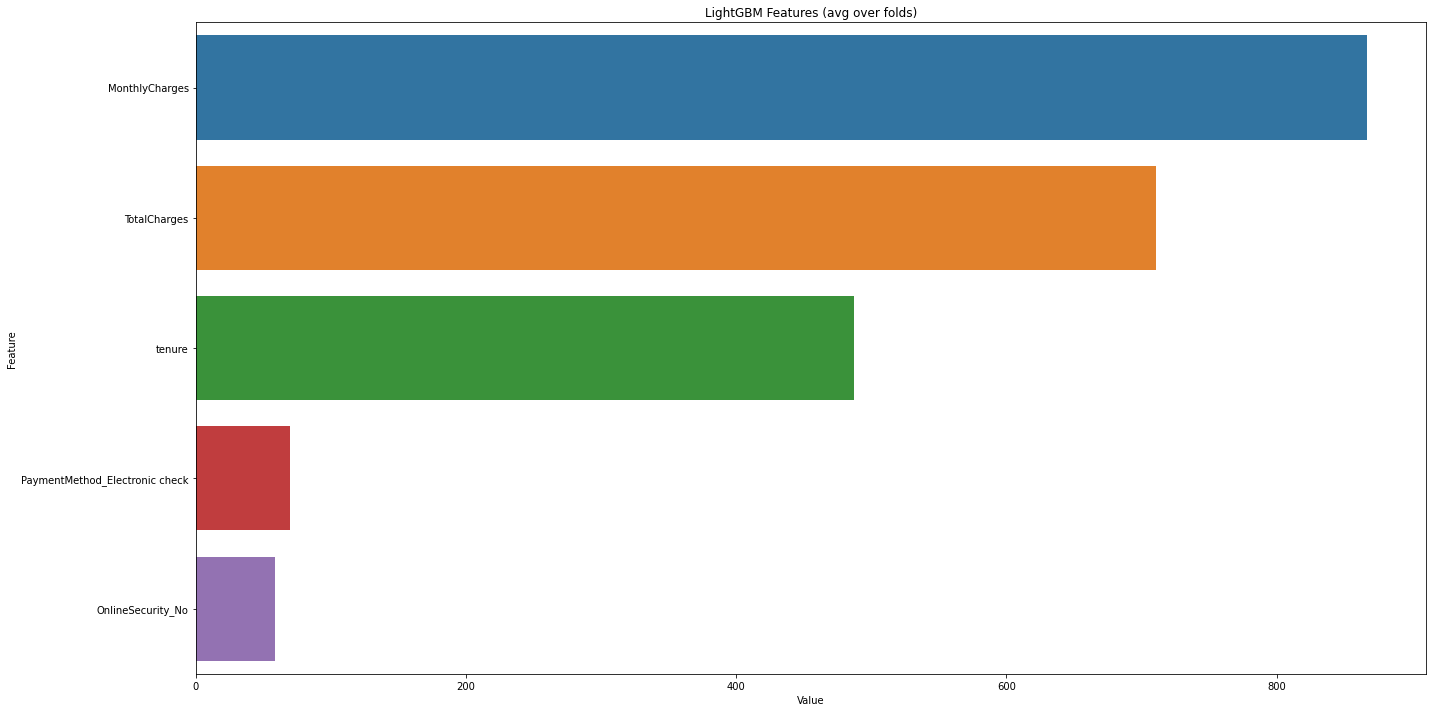

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgbm_clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:5])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

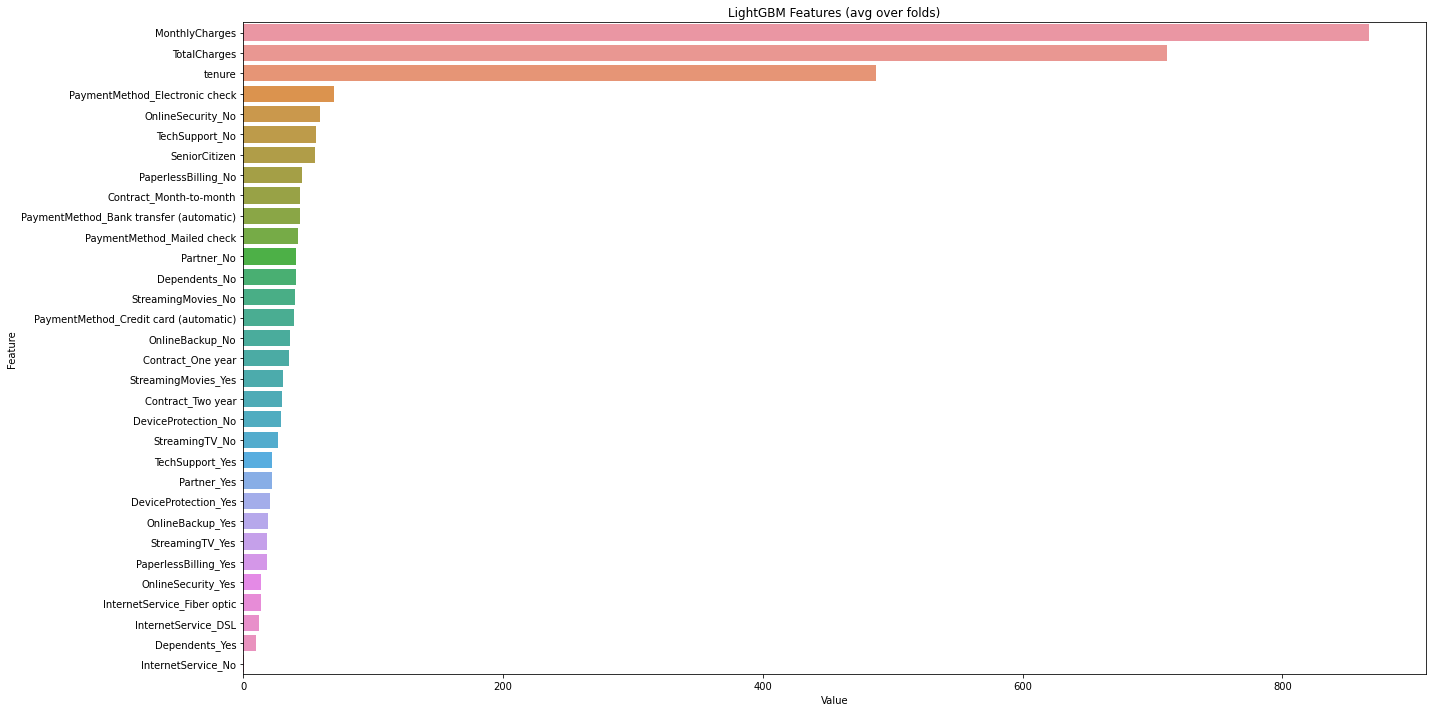

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgbm_clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:32])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
feature_imp.sort_values(by="Value", ascending=False)

,Value,Feature
37,867,MonthlyCharges
36,711,TotalCharges
35,487,tenure
34,70,PaymentMethod_Electronic check
33,59,OnlineSecurity_No
32,56,TechSupport_No
31,55,SeniorCitizen
30,45,PaperlessBilling_No
28,44,Contract_Month-to-month
29,44,PaymentMethod_Bank transfer (automatic)


## use is_unbalanced

Since the dataset is a bit unbalanced since the percentage of yes and no in churn column is not quite equal. Then is_unbalance was used in LGBM


In [42]:
lgbm_clf_ub = lgbm.LGBMClassifier(is_unbalance = True)

lgbm_clf_ub.fit(X_train,y_train)

y_pred_lgbm_ub = lgbm_clf_ub.predict(X_test)

In [43]:

acc_lgbm_ub = accuracy_score(y_pred_lgbm_ub, y_test)
print('LGBM Model accuracy score with unbalanced:{0:0.4f}'.format(acc_lgbm_ub))

LGBM Model accuracy score with unbalanced:0.7432


In [44]:
print(precision_score(y_test,y_pred_lgbm_ub))

0.5077951002227171


In [45]:
print(recall_score(y_test,y_pred_lgbm_ub))

0.7475409836065574


In [46]:
print(f1_score(y_test,y_pred_lgbm_ub))

0.6047745358090186


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[[1269  442]
 [ 154  456]]


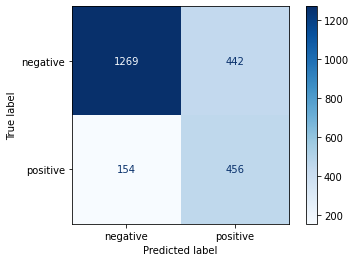

In [47]:
class_names = ['negative','positive']
disp = plot_confusion_matrix(lgbm_clf_ub, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, values_format = '.5g')



print(disp.confusion_matrix)

In [48]:
confusion_matrix(y_test, y_pred_lgbm_ub)


array([[1269,  442],
       [ 154,  456]])

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_lgbm_ub))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1711
           1       0.51      0.75      0.60       610

    accuracy                           0.74      2321
   macro avg       0.70      0.74      0.71      2321
weighted avg       0.79      0.74      0.76      2321



In [50]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_pred_lgbm_ub, y_test))

0.6997865170825461


## Parameter tuning

For better performance of the model, parameter tuning is necessary. Here, we have seven parameters that were tuned: learning rate, n_estimator, max_bin, max_depth, num_leaves, bagging_fraction and min_data_in_leaf.  And we set different target score and try to get a best performance with different target score. 

### for best roc score

In [ ]:
from sklearn.model_selection import GridSearchCV
model_lgbm = lgbm.LGBMClassifier(num_leaves=50,
                              learning_rate=0.1, max_depth=6,
                              metric='auc', bagging_fraction = 0.8,feature_fraction = 0.8,is_unbalance = True)
params_test3={
    'learning_rate': [0.005, 0.05, 0.1, 0.2],
    'n_estimators':range(90,121,10),
    'max_bin':range(180,201,10),
    'max_depth': range(3,5,1),
    'num_leaves':range(10, 51, 10),
    'bagging_fraction':[0.8],
    'min_data_in_leaf':range(20,31,3)
}
gsearch3 = GridSearchCV(estimator=model_lgbm, param_grid=params_test3, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
gsearch3.fit(X_train,y_train)

Fitting 3 folds for each of 1920 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   14.4s


KeyboardInterrupt: ignored

In [ ]:
print(gsearch3.best_params_)

{'bagging_fraction': 0.8, 'learning_rate': 0.05, 'max_bin': 190, 'max_depth': 3, 'min_data_in_leaf': 26, 'n_estimators': 100, 'num_leaves': 10}


In [ ]:
print(gsearch3.best_score_)

0.8509444265010266


we use these parameters to train the model:



In [ ]:
model_best_roc = lgbm.LGBMClassifier(num_leaves=10,
                              learning_rate=0.05, max_depth=3,
                              metric='auc', bagging_fraction = 0.8,max_bin = 190, min_data_in_leaf = 26, n_estimators = 100, is_unbalance = True)

In [ ]:
model_best_roc.fit(X_train,y_train)

y_pred_roc = model_best_roc.predict(X_test)



In [ ]:
print(accuracy_score(y_test,y_pred_roc))

0.7371822490305903


In [ ]:
print(precision_score(y_test,y_pred_roc))

0.5


In [ ]:
print(recall_score(y_test,y_pred_roc))

0.8


In [ ]:
print(f1_score(y_test,y_pred_roc))

0.6153846153846154


In [ ]:
print(roc_auc_score(y_test,y_pred_roc))

0.7573933372296903


In [ ]:
confusion_matrix(y_test, y_pred_roc)

TypeError: ignored

In [ ]:
print(classification_report(y_test,y_pred_roc))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1711
           1       0.50      0.80      0.62       610

    accuracy                           0.74      2321
   macro avg       0.70      0.76      0.71      2321
weighted avg       0.80      0.74      0.75      2321



[[1223  488]
 [ 122  488]]


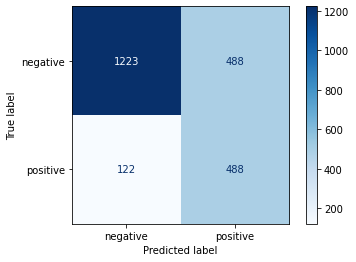

In [ ]:
class_names = ['negative','positive']
disp = plot_confusion_matrix(model_best_roc, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, values_format = '.5g')



print(disp.confusion_matrix)

### for best f1 score

In [ ]:
from sklearn.model_selection import GridSearchCV
model_lgbm = lgbm.LGBMClassifier(num_leaves=50,
                              learning_rate=0.1, max_depth=6,
                              metric='auc', bagging_fraction = 0.8,feature_fraction = 0.8,is_unbalance = True)
params_test4={
    'learning_rate': [0.005, 0.05, 0.1, 0.2],
    'n_estimators':range(80,101,10),
    'max_bin':range(180,220,10),
    'max_depth': range(3,5,1),
    'num_leaves':range(10, 51, 10),
    'bagging_fraction':[0.8],
    'min_data_in_leaf':range(20,31,3)
}
gsearch4 = GridSearchCV(estimator=model_lgbm, param_grid=params_test4, scoring='f1', cv=3, verbose=1, n_jobs=-1)
gsearch4.fit(X_train,y_train)

Fitting 3 folds for each of 1920 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2488 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3588 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 4888 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  5.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(bagging_fraction=0.8,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.8,
                                      importance_type='split',
                                      is_unbalance=True, learning_rate=0.1,
                                      max_depth=6, metric='auc',
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=50,...
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'bagging_fraction': [0.8],
      

In [ ]:
print(gsearch4.best_params_)

{'bagging_fraction': 0.8, 'learning_rate': 0.05, 'max_bin': 190, 'max_depth': 3, 'min_data_in_leaf': 26, 'n_estimators': 100, 'num_leaves': 10}


In [ ]:
print(gsearch4.best_score_)

0.6402678745139778


use these best parameters to train the model and see the performance and matrix

In [ ]:
model_best_f1 = lgbm.LGBMClassifier(num_leaves=10,
                              learning_rate=0.05, max_depth=3,
                               metric = 'auc',bagging_fraction = 0.8,max_bin = 190, min_data_in_leaf = 26, n_estimators = 100, is_unbalance = True)

In [ ]:
model_best_f1.fit(X_train,y_train)

y_pred_f1 = model_best_f1.predict(X_test)

confusion_matrix(y_test, y_pred_f1)

array([[1223,  488],
       [ 122,  488]])

In [ ]:
print(f1_score(y_test, y_pred_f1))

0.6153846153846154


In [ ]:
print(classification_report(y_test,y_pred_f1))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1711
           1       0.50      0.80      0.62       610

    accuracy                           0.74      2321
   macro avg       0.70      0.76      0.71      2321
weighted avg       0.80      0.74      0.75      2321



Model Comparation

$$
\begin{array}{|l|l|l|l|l|l|} 
& \text { accuracy } & \text { precision } & \text { recall } & \text { fl score } & \text { roc auc } \\
\hline \begin{array}{l}
\text { Logistic } \\
\text { regression } \\
\text { default }
\end{array} & \mathbf{0 . 8 0} & \mathbf{0 . 6 4} & 0.52 & 0.58 & 0.71 \\
\hline \begin{array}{l}
\text { LR without } \\
\text { penalty }
\end{array} & \mathbf{0 . 8 0} & \mathbf{0 . 6 4} & 0.54 & 0.58 & 0.71 \\
\hline \text { LGBM default } & 0.79 & 0.60 & 0.52 & 0.56 & 0.72 \\
\hline \text { LGBM unbalance } & 0.74 & 0.51 & 0.75 & 0.60 & 0.70 \\
\hline \begin{array}{l}
\text { LGBM better } \\
\text { parameters }
\end{array} & 0.74 & 0.5 & \mathbf{0 . 8} & \mathbf{0 . 6 2} & \mathbf{0 . 7 6} \\
\hline
\end{array}
$$

##Conclusion 


We can get better accuracy and precision score with the logistic regression model, and higher recall, f1 and roc_auc score using the LGBM model after parameter tuning.


What we can do further: 
Other models like xgboost
For better feature selection: using iterative solutions
